## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [28]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [29]:
# load the data - it is available open source and online

data = pd.read_csv('train.csv')

# display data
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [30]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [31]:
data.columns = data.columns.str.lower()

In [32]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [33]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [34]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [35]:
# drop unnecessary variables

# data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [36]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [37]:
target = 'survived'

In [38]:
vars_num = [c for c in data.columns if data[c].dtypes!='O' and c!=target]

vars_cat = [c for c in data.columns if data[c].dtypes=='O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 6


### Find missing values in variables

In [39]:
# first in numerical variables

data[vars_num].isnull().mean()

passengerid    0.000000
pclass         0.000000
age            0.198653
sibsp          0.000000
parch          0.000000
fare           0.000000
dtype: float64

In [40]:
# now in categorical variables

data[vars_cat].isnull().mean()

name        0.000000
sex         0.000000
ticket      0.000000
cabin       0.771044
embarked    0.002245
title       0.000000
dtype: float64

### Determine cardinality of categorical variables

In [41]:
data[vars_cat].nunique()

name        891
sex           2
ticket      681
cabin       145
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

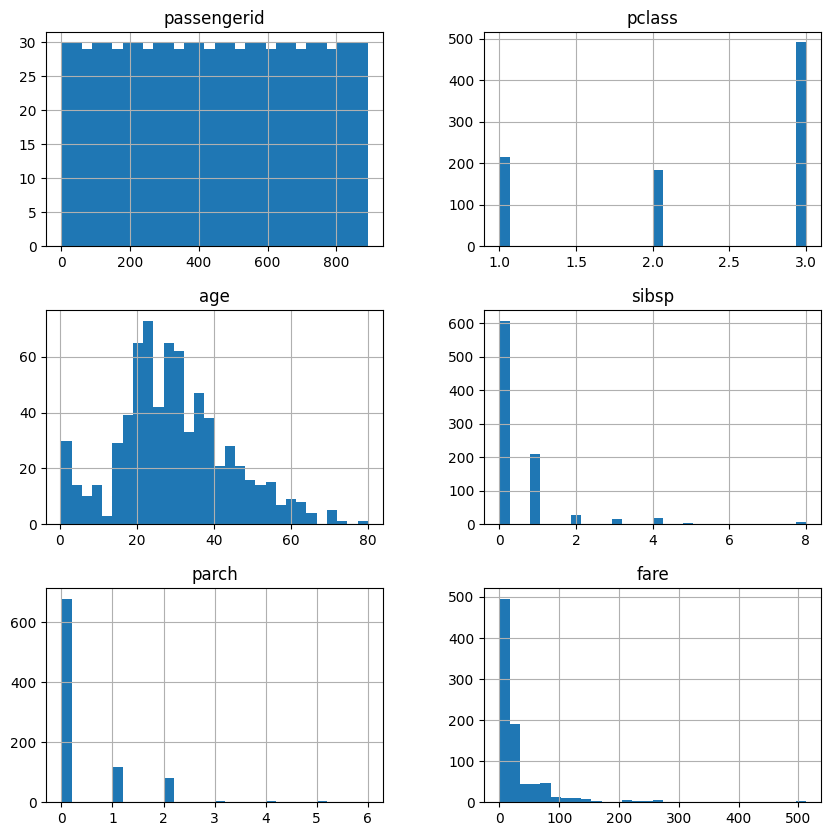

In [42]:
data[vars_num].hist(bins=30, figsize=(10,10))
plt.show()

## Separate data into train and test

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((712, 12), (179, 12))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [44]:
X_train['cabin'] = X_train['cabin'].str[0] # captures the first letter
X_test['cabin'] = X_test['cabin'].str[0] # captures the first letter

X_train['cabin'].unique()

array([nan, 'C', 'B', 'A', 'G', 'E', 'D', 'F', 'T'], dtype=object)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [45]:
for var in ['age', 'fare']:

    # add missing indicator
    X_train[var+'_NA'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_NA'] = np.where(X_test[var].isnull(), 1, 0)

    # replace NaN by median
    median_val = X_train[var].median()

    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)

X_train[['age', 'fare']].isnull().sum()

C:\Users\AliHARCH\AppData\Local\Temp\ipykernel_34884\2665472118.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[var].fillna(median_val, inplace=True)
C:\Users\AliHARCH\AppData\Local\Temp\ipykernel_34884\2665472118.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [46]:
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

In [47]:
X_train.isnull().sum()

passengerid    0
pclass         0
name           0
sex            0
age            0
sibsp          0
parch          0
ticket         0
fare           0
cabin          0
embarked       0
title          0
age_NA         0
fare_NA        0
dtype: int64

In [48]:
X_test.isnull().sum()

passengerid    0
pclass         0
name           0
sex            0
age            0
sibsp          0
parch          0
ticket         0
fare           0
cabin          0
embarked       0
title          0
age_NA         0
fare_NA        0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [49]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the passengers in the dataset
    
    df = df.copy()
    
    tmp = df.groupby(var)[var].count() / len(df)
    
    return tmp[tmp > rare_perc].index


for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

In [50]:
X_train[vars_cat].nunique()

name        1
sex         2
ticket      1
cabin       4
embarked    4
title       4
dtype: int64

In [51]:
X_test[vars_cat].nunique()

name        1
sex         2
ticket      1
cabin       4
embarked    3
title       4
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [52]:
for var in vars_cat:
    
    # to create the binary variables, we use get_dummies from pandas
    
    X_train = pd.concat([X_train,
                         pd.get_dummies(X_train[var], prefix=var, drop_first=True)
                         ], axis=1)
    
    X_test = pd.concat([X_test,
                        pd.get_dummies(X_test[var], prefix=var, drop_first=True)
                        ], axis=1)
    

X_train.drop(labels=vars_cat, axis=1, inplace=True)
X_test.drop(labels=vars_cat, axis=1, inplace=True)

X_train.shape, X_test.shape

((712, 18), (179, 17))

In [53]:
# Note that we have one less column in the test set
# this is because we had 1 less category in embarked.

# we need to add that category manually to the test set

X_train.head()

,passengerid,pclass,age,sibsp,parch,fare,age_NA,fare_NA,sex_male,cabin_C,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
140,141,3,29.0,0,2,15.2458,1,0,False,False,True,False,False,False,False,False,True,False
439,440,2,31.0,0,0,10.5000,0,0,True,False,True,False,False,False,True,True,False,False
817,818,2,31.0,1,1,37.0042,0,0,True,False,True,False,False,False,False,True,False,False
378,379,3,20.0,0,0,4.0125,0,0,True,False,True,False,False,False,False,True,False,False
491,492,3,21.0,0,0,7.2500,0,0,True,False,True,False,False,False,True,True,False,False


In [54]:
X_test.head()

,passengerid,pclass,age,sibsp,parch,fare,age_NA,fare_NA,sex_male,cabin_C,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare
495,496,3,29.0,0,0,14.4583,1,0,True,False,True,False,False,False,True,False,False
648,649,3,29.0,0,0,7.5500,1,0,True,False,True,False,False,True,True,False,False
278,279,3,7.0,4,1,29.1250,0,0,True,False,True,False,True,False,False,False,True
31,32,1,29.0,1,0,146.5208,1,0,False,False,False,False,False,False,False,True,False
255,256,3,29.0,0,2,15.2458,0,0,False,False,True,False,False,False,False,True,False


In [55]:
# we add 0 as values for all the observations, as Rare
# was not present in the test set

X_test['embarked_Rare'] = 0

In [56]:
# Note that now embarked_Rare will be at the end of the test set
# so in order to pass the variables in the same order, we will
# create a variables variable:

variables = [c  for c in X_train.columns]

variables

['passengerid',
 'pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'age_NA',
 'fare_NA',
 'sex_male',
 'cabin_C',
 'cabin_Missing',
 'cabin_Rare',
 'embarked_Q',
 'embarked_Rare',
 'embarked_S',
 'title_Mr',
 'title_Mrs',
 'title_Rare']

### Scale the variables

- Use the standard scaler from Scikit-learn

In [57]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[variables]) 

# transform the train and test set
X_train = scaler.transform(X_train[variables])

X_test = scaler.transform(X_test[variables])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [58]:
# set up the model
# remember to set the random_state / seed

model = LogisticRegression(C=0.0005, random_state=0)

# train the model
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [59]:
# make predictions for test set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8544727861356562
train accuracy: 0.6587078651685393

test roc-auc: 0.8776021080368906
test accuracy: 0.659217877094972

